In [55]:
from collections import defaultdict
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt

In [ ]:
PATH_TO_PAKET_FOLDERS = Path(os.path.expanduser(f'~/Downloads/'))


In [100]:
def read_data_folder(folder):
    i = 0
    header = None
    data_uuids_set = defaultdict(lambda: defaultdict(int))
    filter_by_type = defaultdict(int)
    _fpath = os.path.expanduser(PATH_TO_PAKET_FOLDERS / f'paket_1_1_{folder}_push_nachrichten' / f'{folder}_push_nachrichten.csv')
    with open(_fpath) as f:
        for line in f:
            i += 1
            if i == 1:
                header = line.split(';')
                continue
            app_uuid_index = header.index('app_uuid')
            channel_address_index = header.index('channel_address')

            data_split = line.split(';')
            date_str = data_split[0][:10]
            data_uuids_set[data_split[app_uuid_index]]['notifications'] += 1
            data_uuids_set[data_split[app_uuid_index]][date_str] += 1
            if 'type' not in data_uuids_set[data_split[2]]:
                data_uuids_set[data_split[app_uuid_index]]['type'] = defaultdict(int)
            data_uuids_set[data_split[app_uuid_index]]['type'][data_split[channel_address_index]] += 1


            filter_by_type[data_split[header.index('channel_address')]] += 1
    return header, data_uuids_set, filter_by_type

In [101]:
# Read the data for november
folder = '202011'
header, data_uuids_set, filter_by_type = read_data_folder(folder)
print(datetime.datetime.now(), 'data_ids length', len(data_uuids_set.keys()))


data_ids length 58774


In [109]:
# retrieve some specific ids
data_uuid_to_notifications = {k: v['type']['ARRIVAL_TIME_CHANGE'] for k, v in data_uuids_set.items() if 70 < v['type']['ARRIVAL_TIME_CHANGE'] < 100}
print(data_uuid_to_notifications)


{'51355': 82, '407': 98, '51536': 96, '97924': 71, '16611': 71, '47813': 84, '1549': 71, '52262': 87, '36780': 84, '52369': 82, '52241': 93, '52751': 99, '38645': 94, '67380': 94, '41088': 77, '54936': 72, '1264': 71, '53995': 72, '44317': 72, '53700': 76, '91098': 98, '35990': 95, '38184': 96, '102654': 76, '44855': 94, '19233': 71, '63503': 93, '81837': 73, '21556': 74, '46145': 81, '24187': 91, '25401': 79, '39833': 90, '42951': 73, '48721': 87, '49507': 79, '50355': 89, '8': 78, '351': 85, '44662': 77, '37030': 85, '95492': 71, '44616': 77, '38491': 88, '40733': 77, '2191': 94, '51196': 99, '1949': 95, '57483': 98, '45009': 81, '77662': 77, '1662': 79, '37771': 85, '38983': 86, '39141': 85, '58080': 99, '37120': 99, '42489': 75, '69285': 75, '67865': 80, '2012': 97, '64463': 83, '58492': 73, '100982': 88, '58368': 91, '3639': 72, '58785': 81, '37967': 83, '61054': 85, '58795': 87, '3741': 87, '4359': 71, '45480': 90, '38864': 77, '37679': 91, '50712': 72, '44232': 73, '80907': 92, 

### Plot the distribution of notification across app installations

max 0
mean 0.0 std 0.0
median 0.0


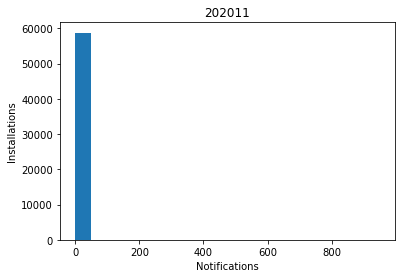

In [118]:
push_notifications = np.asarray([v['type']['notifications'] for k, v in data_uuids_set.items()])

print('max', np.max(push_notifications))
print('mean', np.nanmean(push_notifications), 'std', np.nanstd(push_notifications))
print('median', np.median(push_notifications))

plt.hist(push_notifications[push_notifications < 1000], np.arange(0, 1000, 50))
# plt.scatter(x=int(np.nanmean(push_notifications[push_notifications < 1000])), y=0)
plt.xlabel('Notifications')
plt.ylabel('Installations')
plt.title(folder)
plt.show()

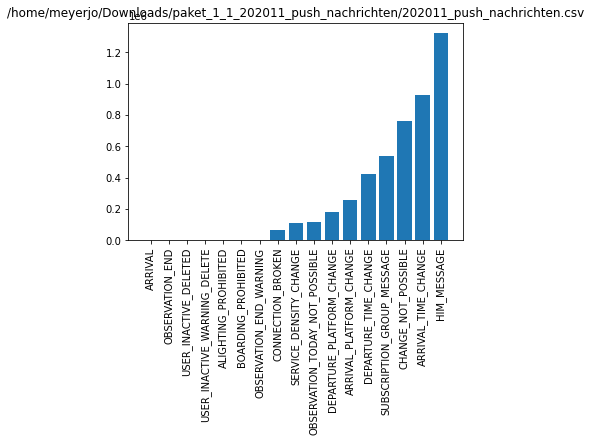

In [63]:
key_vals = [(k, v) for k, v in filter_by_type.items()]
key_vals = sorted(key_vals, key=lambda x: x[1])


plt.bar(np.arange(0, len(key_vals)), [x[1] for x in key_vals])
plt.xticks(np.arange(0, len(key_vals)), [x[0] for x in key_vals], rotation='vertical')
plt.title(folder)
plt.show()


max 30
mean 11.859104365876068
median 11.0


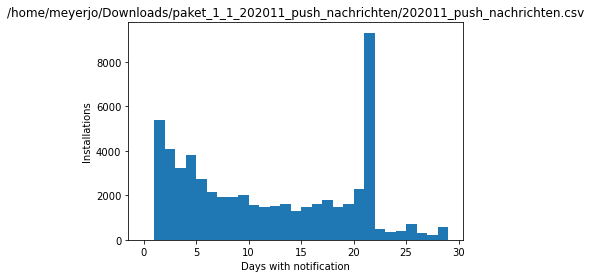

In [64]:
push_notifications_per_day = np.asarray([len(v.keys()) - 1 for k, v in data_uuids_set.items()])
print('max', np.max(push_notifications_per_day))
print('mean', np.nanmean(push_notifications_per_day))
print('median', np.median(push_notifications_per_day))

plt.hist(push_notifications_per_day, np.arange(0, 30, 1))
plt.xlabel('Days with notification')
plt.ylabel('Installations')
plt.title(folder)
plt.show()


In [95]:
import re

# Handle the filtering
def get_additional_parameters(rt_connection_field):
    rt_connection_arrivalstop = re.search('ArrivalStop=RtStop{StopName=([^}]*)', rt_connection_field).group(1)

    # we split the resulting regex group up. We have now comma separated strings. Most of them have a = in them
    # specifying an individual key=val pair. Some are just string
    data_splits = rt_connection_arrivalstop.split(',')
    details = dict()
    details['string'] = []
    for d in data_splits:
        if '=' in d:
            _s = d.split('=')
            details[_s[0]] = _s[1]
        else:
            details['string'].append(d)

    details['string'] = ','.join(details['string'])
    return details


In [97]:
import os
# Specify the app_uuid which you want to export. You can add multiple ids to the list
ids_to_filter = ['51578']
# Specify the folders which shall be looked at
folders = ['202010', '202011', '202012']
# specify the channel_address types which shall be exported
channel_addresses = ['CANCELLATION', 'ARRIVAL_TIME_CHANGE', 'DEPARTURE_TIME_CHANGE']

# specify the additional fields for the folder
additional_detail_fields = ['ArrivalDelay', 'PlannedArrivalTime', 'PlannedPlatform', 'RtPlatform', 'StopId', 'string']

def filter_by_id(_fpath, ids_to_filter, filter_channels):
    lines_by_id = defaultdict(list)
    i = 0
    header = None
    with open(_fpath) as f:
        for line in f:
            i+=1
            if i == 1:
                for id in ids_to_filter:
                    lines_by_id[id].append(line + ';' + ';'.join(additional_detail_fields))
                    header = line.split(';')
                continue

            line = line.strip()

            data_split = line.split(';')
            if data_split[header.index('app_uuid')] not in ids_to_filter:
                continue
            if data_split[header.index('channel_address')] not in filter_channels:
                continue

            # read the rtconnectionevent fields to some degree
            rt_connection = data_split[header.index('RtConnectionEvent')]
            details = get_additional_parameters(rt_connection)

            # make them csv exportable
            v = []
            for add_field in additional_detail_fields:
                # escape potential semicolons
                details[add_field].replace(';', '%%%')
                v.append(details[add_field])


            lines_by_id[data_split[header.index('app_uuid')]].append(line + ';' + ';'.join(v) + '\n')

    return lines_by_id

for folder in folders:
    print(f'Going through: {folder}')
    _fpath = os.path.expanduser(f'~/Downloads/paket_1_1_{folder}_push_nachrichten/{folder}_push_nachrichten.csv')

    lines_by_id = filter_by_id(_fpath, ids_to_filter, channel_addresses)

    for id, lines in lines_by_id.items():
        with open(f'./output_{folder}_{id}.csv', 'w') as f:
            f.writelines(lines)

Going through: 202010
Going through: 202011
Going through: 202012


In [86]:
import copy

rt = copy.deepcopy(lines_by_id)



In [ ]:
# Filterung Pünktlichkeit als erstes nach: chanel_address: CANCELLATION, ARRIVAL_TIME_CHANGE (evtl auch DEPARTURE_TIME_CHANGE)
#
# Dann FIlterung welche Züge/Verbindungen überhaupt abonniert:
# mit TtConnectionEvent ArrivalStop->StopName & PlannedArrivalTime, Arrival Delay (für Pünktlichkeit) und DepartureStop->Stop Name und Planned Departure (evtl noch Departure Delay);


In [93]:
import re

rt_connection_entry = rt['255887'][1].split(';')[-2]
print(rt_connection_entry)
rt_connection_arrivalstop = re.search('ArrivalStop=RtStop{StopName=([^}]*)', rt_connection_entry).group(1)
rt_planned_arrivaltime = re.search('(PlannedArrivalTime)=([^,]*)', rt_connection_entry).groups()
rt_arrival_delay = re.search('(ArrivalDelay)=([^,]*)', rt_connection_entry).groups()


# we split the resulting regex group up. We have now comma separated strings. Most of them have a = in them
# specifying an individual key=val pair. Some are just string
data_splits = rt_connection_arrivalstop.split(',')
details = dict()
details['string'] = []
for d in data_splits:
    if '=' in d:
        _s = d.split('=')
        details[_s[0]] = _s[1]
    else:
        details['string'].append(d)
# details[rt_planned_arrivaltime[0]] = rt_planned_arrivaltime[1]
# details[rt_arrival_delay[0]] = rt_arrival_delay[1]

print(sorted(list(details.keys())))



RtConnectionEvent{ConSections=[RtConsection{MinimalChangeTime=2,ArrivalStop=RtStop{StopName=Süderstraße, Hamburg,PlannedPlatform=null,ArrivalDelay=0,PlannedArrivalTime=2020-12-04T18:03+01:00,StopId=895125,RtPlatform=null},Category=Bus,Number=154,DepartureStop=RtStop{StopName=Berliner Tor (Bürgerweide) (S+U), Hamburg,PlannedPlatform=null,StopId=694886,PlannedDepartureTime=2020-12-04T18:00+01:00,RtPlatform=null,DepartureDelay=0},FreeTextIds=[],ChangeNotPossible=false,RtAttributes=null,Broken=false},RtConsection{MinimalChangeTime=3,ArrivalStop=RtStop{StopName=Hammerbrook (Süd) (S), Hamburg,PlannedPlatform=null,ArrivalDelay=0,PlannedArrivalTime=2020-12-04T18:08+01:00,StopId=694853,RtPlatform=null},Category=Bus,Number=112,DepartureStop=RtStop{StopName=Süderstraße, Hamburg,PlannedPlatform=null,StopId=895125,PlannedDepartureTime=2020-12-04T18:07+01:00,RtPlatform=null,DepartureDelay=0},FreeTextIds=[],ChangeNotPossible=false,RtAttributes=null,Broken=false},RtConsection{MinimalChangeTime=-1,Arri